In [2]:
import gymnax
import gymnasium as gym
import jax
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from RLinJAX import *
import pickle

# Mountain Car Environment 

In [3]:
env = gym.make("MountainCar-v0")

The mountain car environment is a classic reinforcement learning environment where the agent is challenged in terms of control and decision-making. This environment is used to test various reinforcement learning algorithms.

## Problem Description

In this environment the agent controls a car that is located at the bottom of a valley, and the goal is to reach the top of the hill. However, the car doesn't have enough speed to reach the top, and has to use momentum to gain speed to reach the goal, where elements such as position, speed and gravity are effects that the agent has to take into account.

## Key Components

This environment has 3 discrete actions in the action space:

In [4]:
action_space = env.action_space
print(action_space)
print("Number of actions:", action_space.n)

Discrete(3)
Number of actions: 3


These actions can be:
- 0: accelerate to the left 
- 1: do not accelerate
- 2: accelerate to the right

The observation space is represented by a two-dimensional array consisting of:

- Position: The position of the car on the x-axis where the values are between -1.2 and 0.6.
- Velocity : The velocity of the car with values between -0.07 and 0.07

In [5]:
observation_space = env.observation_space
print(observation_space)
print("Observation space low values:", observation_space.low)
print("Observation space high values:", observation_space.high)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Observation space low values: [-1.2  -0.07]
Observation space high values: [0.6  0.07]


## Transition Dynamics

Given a certain action, the car uses the following formulas to calculate its next position and speed:

- velocity(t+1) = velocity(t) + (action - 1) * force - cos(3 * position(t)) * gravity

- position(t+1) = position(t) + velocity(t+1)

Force assumes a value of 0.001 and gravity assumes a value of 0.0025.

## Reward 

The objective of this environment is to reach the top of the hill and every time this agent executes a timestep its reward is penalized with -1.

## Starting State and Episode End 

At the start of each episode, the car's position takes on a random value between -0.6 and -0.4 and a velocity always equal to 0.

This episode ends in two situations:

- The car reaches a position greater than or equal to 0.5 (goal position, at the top of the hill on the right).

- The agent fails to reach the goal before using the maximum number of steps. And the episode ends


# Q-Learning

Q-Learning is a model-free, off-policy reinforcement learning algorithm used to find an optimal policy in Markov Decision Processes (MDPs). It works by learning a Q-function, which estimates the expected future rewards for taking a particular action in a given state and following the optimal policy thereafter.

<img src="q-learning-equation.png" alt='q-learning-equation.png' width="500"/>


This environment has a continuous observation space, as already described, which contains two continuous variables.

Since the Q-learning algorithm needs a table to store the discrete values of action and state pairs, it cannot directly use continuous values from the observation space. Therefore, the observation space is discretized into a finite space of bins.

In this implementation, 20 bins were assigned to the position values and 15 bins to the velocity values, since the range of values for position is greater than for velocity.

These values assigned to the bins result in a q-table with a matrix of dimensions equal to:

Q-Table Dim = 900 = 3 (number of actions) * 15 (velocity bins) * 20 (position bins)

In [6]:
num_position_bins = 20
num_velocity_bins = 15
position_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num_position_bins)
velocity_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num_velocity_bins)

print("Position discrite positions (bins)")
print(position_bins)
print("Velocity discrite velocity values (bins)")
print(velocity_bins)

Position discrite positions (bins)
[-1.2        -1.1052632  -1.0105264  -0.9157895  -0.8210527  -0.72631586
 -0.631579   -0.5368421  -0.4421053  -0.34736848 -0.2526316  -0.15789473
 -0.06315792  0.0315789   0.12631583  0.22105265  0.31578946  0.41052628
  0.5052631   0.6       ]
Velocity discrite velocity values (bins)
[-0.07       -0.06       -0.05       -0.04       -0.03       -0.02
 -0.01        0.          0.01        0.02        0.02999999  0.04
  0.05        0.05999999  0.07      ]


In [7]:
# Q-table initialization
num_actions = env.action_space.n

The discretize_state function is needed to convert the environment's continuous position and velocity values into discrete indices that can be used to access and update the Q-table. Since Q-learning works in a finite, discrete state space, this function ensures that the continuous state values are approximated to their closest discrete intervals.

In [8]:
def discretize_state(state, num_position_bins, num_velocity_bins):
    position, velocity = state
    position_bin = np.digitize(position, position_bins) - 1  
    velocity_bin = np.digitize(velocity, velocity_bins) - 1
    position_bin = np.clip(position_bin, 0, num_position_bins - 1)
    velocity_bin = np.clip(velocity_bin, 0, num_velocity_bins - 1)
    return position_bin, velocity_bin

## Action Selection

In this Q-learning implementation, the action was selected using an epsilon-greedy strategy to balance exploration (choosing a random state) and exploitation (choosing the action with the highest Q-value).

The epsilon rate serves to reduce the value of the epsilon over the course of the episodes by encouraging exploration in the early episodes and exploitation in the later episodes. 

In [9]:
def epsilon_greedy(state, epsilon, q_values_table, num_actions):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(num_actions))
    else:
        position_bin, velocity_bin = state
        return np.argmax(q_values_table[position_bin, velocity_bin])

In [10]:
def train_q_learning(env, num_position_bins, num_velocity_bins, num_episodes, num_steps, alpha, gamma, epsilon, epsilon_decay, min_epsilon):
    # Initialize Q-table
    num_actions = env.action_space.n
    q_values_table = np.zeros((num_position_bins, num_velocity_bins, num_actions))

    episode_rewards = []
    episode_lengths = []
    goal_reached = False
    best_q_table = None
    best_reward = -float("inf")  

    for episode in range(num_episodes):
        # Initialize the state by resetting the environment
        state, _ = env.reset()
    
        # Discretize the state
        discretized_state = discretize_state(state, num_position_bins, num_velocity_bins)
    
        total_reward = 0
        for step in range(num_steps):
            # Select the action using the epsilon-greedy policy
            action = epsilon_greedy(discretized_state, epsilon, q_values_table, num_actions)
    
            # Perform the selected action and store the next state information
            next_state, reward, done, _, _ = env.step(action)
    
            # Discretize the next state
            discretized_next_state = discretize_state(next_state, num_position_bins, num_velocity_bins, env)
    
            # Find the action a' with the maximum Q-value in the next state
            next_action = np.argmax(q_values_table[discretized_next_state])
    
            # Update Q-value of the state-action pair using the Q-learning update rule
            q_values_table[discretized_state[0], discretized_state[1], action] += alpha * (
                reward + gamma * q_values_table[discretized_next_state[0], discretized_next_state[1], next_action]
                - q_values_table[discretized_state[0], discretized_state[1], action]
            )
    
            # Update current state to next state
            discretized_state = discretized_next_state
    
            # Accumulate total reward
            total_reward += reward

            # If the current state is the terminal state, break
            if done:
                goal_reached = True
                break
                
        
        if total_reward > best_reward:
            best_reward = total_reward
            best_q_table = q_values_table.copy()  

        episode_rewards.append(total_reward)
        episode_lengths.append(step + 1)  

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Calculate averages
    average_reward_all_episodes = np.mean(episode_rewards)
    average_reward_last_100_episodes = (np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else average_reward_all_episodes)

    result = {
        "average_reward_all_episodes": average_reward_all_episodes,
        "average_reward_last_100_episodes": average_reward_last_100_episodes,
        "episode_lengths": episode_lengths,
        "episode_rewards": episode_rewards,
        "alpha": alpha,
        "gamma": gamma,
        "epsilon_decay": epsilon_decay,
        "min_epsilon": min_epsilon,
        "goal_reached": goal_reached,
        "q_values_table": q_values_table, 
        "best_q_table": best_q_table,  
    }

    return result


## Hyperparameters 

In reinforcement learning, the performance of an agent is highly dependent on parameters, which indicate how the agent learns and interacts with the environment. 
Q-learning relies on some hyperparameters such as learning rate (α), discount factor (γ), and exploration settings (ϵ) to balance exploration and exploitation effectively and optimize the learning process.

To address this, we implemented a systematic search for these parameters and their different combinations to identify a combination that maximizes the agent's performance.

The parameters that were used were:

- Alpha: Controls how quickly the agent updates values in the q table 
- Gamma: Represents the importance of future rewards.
- Epsilon Decay: Regulates the amount of exploration throughout the episodes.
- Minimum Epsilon: Establishes a minimum limit for exploration after decreasing through epsilon decay.

In [11]:
# Load the results from the pickle file
with open("q_learning_results.pickle", "rb") as f:
    all_results = pickle.load(f)

max_avg_reward = all_results[0]["average_reward_all_episodes"]
max_avg_reward_index = 0

max_avg_last_100 = all_results[0]["average_reward_last_100_episodes"]
max_avg_last_100_index = 0

for i in range(1, len(all_results)):
    result = all_results[i]
    
    if result["average_reward_all_episodes"] > max_avg_reward:
        max_avg_reward = result["average_reward_all_episodes"]
        max_avg_reward_index = i

    if result["average_reward_last_100_episodes"] > max_avg_last_100:
        max_avg_last_100 = result["average_reward_last_100_episodes"]
        max_avg_last_100_index = i

print(f"Maximum average reward (all episodes): {max_avg_reward} at index {max_avg_reward_index}")
print(f"Maximum average reward (last 100 episodes): {max_avg_last_100} at index {max_avg_last_100_index}")

print("\nParameters for max average reward (all episodes):")
params_all_episodes = {
    "alpha": all_results[max_avg_reward_index]["alpha"],
    "gamma": all_results[max_avg_reward_index]["gamma"],
    "epsilon_decay": all_results[max_avg_reward_index]["epsilon_decay"],
    "min_epsilon": all_results[max_avg_reward_index]["min_epsilon"],
    "goal_reached": all_results[max_avg_reward_index]["goal_reached"],
}
print(params_all_episodes)

print("\nParameters for max average reward (last 100 episodes):")
params_last_100 = {
    "alpha": all_results[max_avg_last_100_index]["alpha"],
    "gamma": all_results[max_avg_last_100_index]["gamma"],
    "epsilon_decay": all_results[max_avg_last_100_index]["epsilon_decay"],
    "min_epsilon": all_results[max_avg_last_100_index]["min_epsilon"],
    "goal_reached": all_results[max_avg_last_100_index]["goal_reached"],
}
print(params_last_100)

episode_rewards_best_average = all_results[max_avg_reward_index]["episode_rewards"]
episode_rewards_best_last_100 = all_results[max_avg_last_100_index]["episode_rewards"]

episode_lengths_best_average = all_results[max_avg_reward_index]["episode_lengths"]
episode_lengths_best_last_100 = all_results[max_avg_last_100_index]["episode_lengths"]

Maximum average reward (all episodes): -167.31436 at index 30
Maximum average reward (last 100 episodes): -141.72 at index 32

Parameters for max average reward (all episodes):
{'alpha': 0.1, 'gamma': 0.99, 'epsilon_decay': 0.999, 'min_epsilon': 0.05, 'goal_reached': True}

Parameters for max average reward (last 100 episodes):
{'alpha': 0.1, 'gamma': 0.99, 'epsilon_decay': 0.9995, 'min_epsilon': 0.05, 'goal_reached': True}


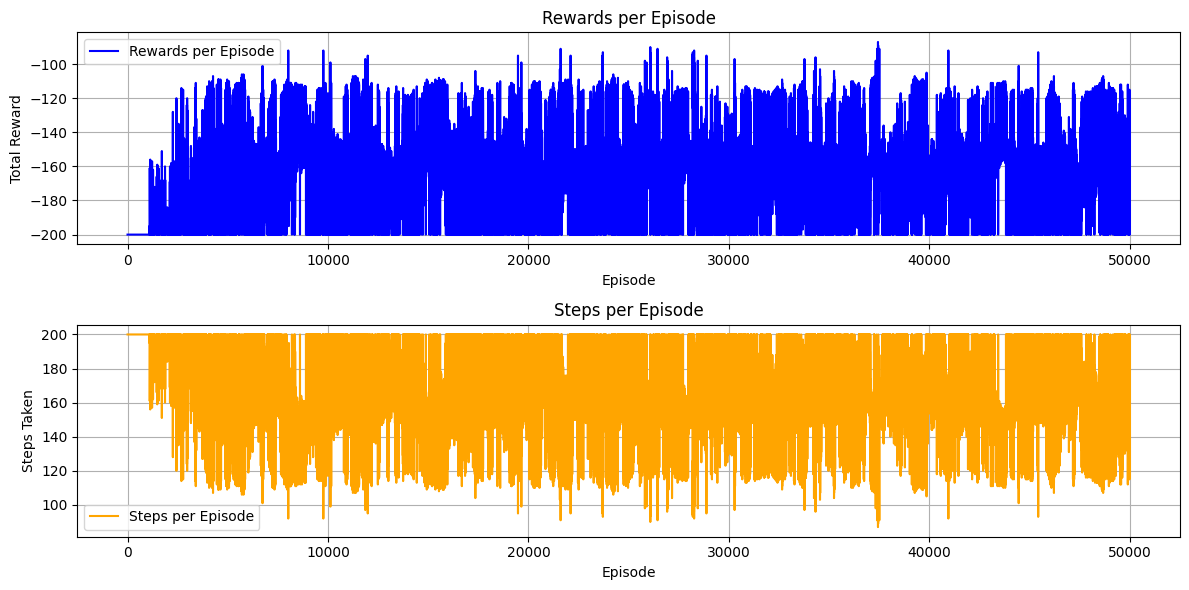

In [12]:
# Plot Rewards per Episode
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(episode_rewards_best_average, label="Rewards per Episode", color="blue")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards per Episode")
plt.grid(True)
plt.legend()

# Plot Steps per Episode
plt.subplot(2, 1, 2)
plt.plot(episode_lengths_best_average, label="Steps per Episode", color="orange")
plt.xlabel("Episode")
plt.ylabel("Steps Taken")
plt.title("Steps per Episode")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

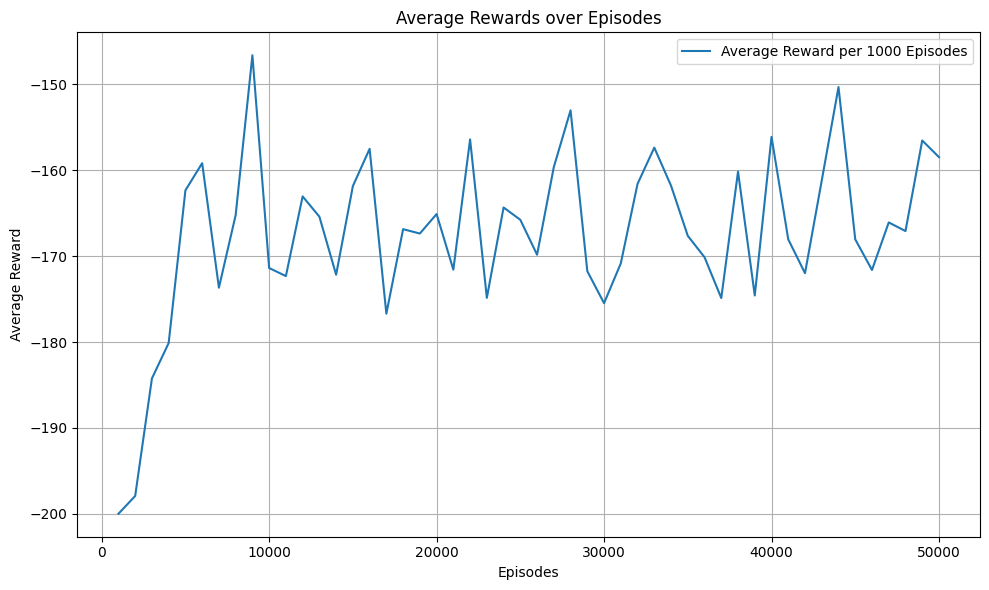

In [28]:
# Use your actual data
episode_rewards_best_average = all_results[max_avg_reward_index]["episode_rewards"]

# Calculate averages for every 1000 episodes
chunk_size = 1000
averaged_rewards = [
    np.mean(episode_rewards_best_average[i:i + chunk_size])
    for i in range(0, len(episode_rewards_best_average), chunk_size)
]

# Generate x-axis values multiplied by 1000 to match original episode indices
x_values = np.arange(1, len(averaged_rewards) + 1) * chunk_size

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, averaged_rewards, label="Average Reward per 1000 Episodes")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Average Rewards over Episodes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter

env = gym.make("MountainCar-v0", render_mode="rgb_array")

def q_learning_gif(env, q_table, num_position_bins, num_velocity_bins, output_file):
    state, _ = env.reset()  
    done = False

    fig, ax = plt.subplots()
    frames = []

    while not done:
        position_bin, velocity_bin = discretize_state(state, num_position_bins, num_velocity_bins)
        
        action = np.argmax(q_table[position_bin, velocity_bin])
        
        state, _, done, _, _ = env.step(action)

        frame = env.render()  
        frames.append(frame)

   
    ani = PillowWriter(fps=30)
    ani.setup(fig, output_file, dpi=100)
    for frame in frames:
        ax.clear()
        ax.imshow(frame)
        ax.axis('off')
        ani.grab_frame()
    ani.finish()
    plt.close(fig)



# Save the GIF using Matplotlib
best_q_table = all_results[max_avg_last_100_index]["best_q_table"]
q_learning_gif(env, best_q_table, num_position_bins, num_velocity_bins, "mountain_car_q_learning.gif")
